## **Drive Access**

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Libraries

In [90]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import cv2
import time
import json
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import xml.etree.ElementTree as ET
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [91]:
sys.path.append('/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/')
from train import train_model
from data_utils import create_validation_data
from vis_utils import imshow

**Annotation & Helper** functions

In [92]:
def get_model(model_name, num_classes, pretrained=True):
    return models.__dict__[model_name](pretrained)

import xml.etree.ElementTree as ET


def read_all_annotations(root_dir, convert_labels_to_int=True):
    """
    root_dir: پوشه‌ای که فایل‌های .xml در آن قرار دارند
    convert_labels_to_int: اگر True باشد، labelها به عدد تبدیل می‌شوند
    """
    annos = {}
    label_to_int = {}
    label_counter = 0

    xml_files = glob(os.path.join(root_dir, '*.xml'))

    for xml_file in xml_files:
        tree = ET.parse(xml_file)
        root = tree.getroot()

        filename = root.find('filename').text.strip()
        objects = root.findall('object')

        if not objects:
            continue

        boxes = []
        labels = []

        for obj in objects:
            label = obj.find('name').text.strip()

            if convert_labels_to_int:
                if label not in label_to_int:
                    label_to_int[label] = label_counter
                    label_counter += 1
                label = label_to_int[label]  # تبدیل به عدد

            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        annos[filename] = {
            'boxes': boxes,
            'labels': labels
        }

    return annos


def bbox_to_r1c1r2c2(bbox):
    x = bbox['x']
    y = bbox['y']
    w = bbox['width']
    h = bbox['height']
    return [y, x, y + h, x + w]  # [r1, c1, r2, c2]


def plot_bbox(img, bbox, w, h, color='red'):
    """ Plot bounding box on the image tensor.
    """
    img = img.cpu().numpy().transpose((1, 2, 0))  # (H, W, C)

    # denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # scale
    hs, ws = img.shape[:2]
    h_scale = h / hs
    w_scale = w / ws

    bb = np.array(bbox, dtype=np.float32)
    bx, by = bb[1], bb[0]
    bw = bb[3] - bb[1]
    bh = bb[2] - bb[0]

    bx *= w * w_scale
    by *= h * h_scale
    bw *= w * w_scale
    bh *= h * h_scale

    # scale image
    img = cv2.resize(img, (w, h))

    # create BB rectangle
    rect = plt.Rectangle((bx, by), bw, bh, color=color, fill=False, lw=3)

    # plot
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(img)
    plt.gca().add_patch(rect)
    plt.show()

## Data

In [93]:
DATA_DIR = "/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets"

train_dir = f'{DATA_DIR}/train'
print(train_dir)
valid_dir = f'{DATA_DIR}/valid'
print(valid_dir)
#anno_dir = f'{DATA_DIR}/annotations'

sz = 299  # image size
bs = 32   # batch size
model_name = 'resnet34'
num_classes = 8

/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train
/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/valid


### Files structure

In [94]:
print(os.listdir(DATA_DIR))

['README.dataset.txt', 'README.roboflow.txt', 'train', 'valid', 'test', 'annotations']


In [95]:
# all images for each fish class is in a separate directory
print(os.listdir(f'{DATA_DIR}/train'))

['881_png.rf.a9d8cc00e9522b8e7fca302c44516e15.xml', '609_png.rf.71155561209d46822d238361ccf00977.xml', '1867_png.rf.158504767e0c1c729eb956e284226bc5.xml', '1260_png.rf.a17d5b6f475a669d9e25dde83ce6a2cb.xml', '1160_png.rf.34dfa2dfbafc88ab4ccf92d4bde83886.xml', '1086_png.rf.f7581982f5765b920ee8b023b2efb628.xml', '220_png.rf.2b23b31bee7061e6670b6e65d9abc752.xml', '715_png.rf.81ae9abda0eedc6f5dad71b6f3091249.xml', '1828_png.rf.f46ddf6697b01256a1b53ae30f0ef321.xml', '1123_png.rf.e2fb70241f29bf1a81217283d4bd7fcc.xml', '1256_png.rf.473cc23534d7da4fa536fbdf1887f5a3.xml', '268_png.rf.47f7926b3be1b2b8ba38b2d83ab0eabe.xml', '221_png.rf.f0e320d4667864be19d370937374209c.xml', '1162_png.rf.a4ef34a1700f800d8ff46c1af1be73c1.xml', '948_png.rf.dd1c8e9d18360ccd86b3ec8e876b687f.xml', '663_png.rf.ff214636bf86b07138c0413031532af8.xml', '674_png.rf.b15aa49eb971813387542ae9ea664609.xml', '633_png.rf.fe6cd5f42edaedbb6a73c67e60e76b2b.jpg', '1590_png.rf.d7e6a5eaba11ece5074b940abf2dadd2.xml', '1456_png.rf.2e60df59

In [96]:
files = glob(f'{DATA_DIR}/train/*.jpg')

files[:5]

['/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/633_png.rf.fe6cd5f42edaedbb6a73c67e60e76b2b.jpg',
 '/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/515_png.rf.f9121afe38c38ff6d75595a923992326.jpg',
 '/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/94_png.rf.416143d4efdad648b71312a9541e0a4c.jpg',
 '/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/767_png.rf.fd084782d91a43632664e9e0e600c144.jpg',
 '/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/1863_png.rf.3ba919653775064d6b9f80b8a002b0f3.jpg']

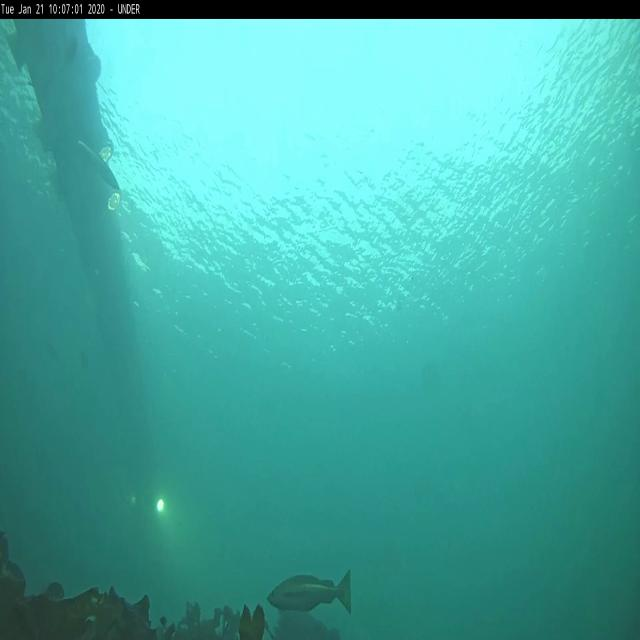

In [97]:
Image.open(files[3])

### Fish Dataset

Creat a simple class for images

In [98]:
#چون فایل اطلاعات عکس ها و عکس ها با هم قاطی اند و پوشه بندی جداگانه نشده اند
#عکس ها یعنی عکس هر ماهی تو پوشه خودش، اول یه کلاس ساده میسازیم کهفقط عکس ها رو لیست کنه بعد میفرستیم به کلاسFishdataset
from torchvision.datasets.folder import default_loader

class SimpleImageDataset:
    def __init__(self, root):
        self.imgs = [(f, 0) for f in glob(os.path.join(root, '*.jpg'))]
        self.classes = ['fish']  # مقدار اولیه فقط


In [211]:
import os
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch

# class FishDataset(Dataset):
#     def __init__(self, ds, bboxes, classes, class_to_idx, sz=299):
#         """
#         ds: مجموعه تصاویر (از ImageFolder)
#         bboxes: دیکشنری شامل 'boxes' و 'labels' برای هر تصویر
#         classes: لیست کلاس‌ها
#         class_to_idx: دیکشنری نگاشت نام کلاس به اندیس
#         sz: اندازه نهایی تصویر
#         """
#         self.imgs = ds.imgs  # لیست تاپل‌های (مسیر, label)
#         self.classes = classes
#         self.bboxes = bboxes
#         self.class_to_idx = class_to_idx
#         self.sz = sz
#         self.image_paths = [img[0] for img in ds.imgs]  # ذخیره مسیرهای تصاویر
#         # نمایش کلاس‌های موجود
#         print("کلاس‌های موجود:")
#         print(self.classes)
#         print("\nclass_to_idx:")
#         print(self.class_to_idx)

#         # پیدا کردن برچسب‌های منحصر به فرد در دیتاست
#         all_labels = set()
#         for bbox_info in self.bboxes.values():
#           all_labels.update(map(str, bbox_info['labels']))

#           print("\nبرچسب‌های موجود در دیتاست:", all_labels)

#         # برچسب‌های گم‌شده
#         missing_labels = all_labels - set(self.class_to_idx.keys())
#         if missing_labels:
#           print("\n⚠️ برچسب‌های گم‌شده:", missing_labels)
#           # اضافه کردن خودکار (اختیاری)
#           for idx, label in enumerate(missing_labels, start=len(self.class_to_idx)):
#             self.class_to_idx[label] = idx
#             print(f"اضافه شد: {label} -> {idx}")

#         self.tfms = transforms.Compose([
#             transforms.Resize((sz, sz)),
#             transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406],
#                                [0.229, 0.224, 0.225])
#         ])

#     def __getitem__(self, index):
#      img_path, _ = self.imgs[index]
#      img_name = os.path.basename(img_path)

#      image = Image.open(img_path).convert('RGB')
#      w, h = image.size
#      w_scale = self.sz / w
#      h_scale = self.sz / h

#      image = self.tfms(image)

#      boxes = []
#      labels = []

#      if img_name in self.bboxes:
#         bbox_info = self.bboxes[img_name]
#         for box, label in zip(bbox_info['boxes'], bbox_info['labels']):
#             # تبدیل به مختصات نسبی [0-1]
#             x1 = box[0] / w
#             y1 = box[1] / h
#             x2 = box[2] / w
#             y2 = box[3] / h

#             boxes.append([x1, y1, x2, y2])

#             # تبدیل برچسب با بررسی وجود در class_to_idx
#             try:
#                 # بررسی هم برای عددی و هم رشته‌ای
#                 if isinstance(label, str):
#                     label_idx = self.class_to_idx[label]
#                 else:
#                     label_idx = self.class_to_idx[str(label)]
#                 labels.append(label_idx)
#             except KeyError:
#                 print(f"⚠️ هشدار: برچسب {label} (نوع: {type(label)}) در class_to_idx وجود ندارد!")
#                 continue  # یا مقدار پیش‌فرض قرار دهید

#                 boxes = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32)
#                 labels = torch.tensor(labels, dtype=torch.long) if labels else torch.zeros((0,), dtype=torch.long)
#                 return image, labels, boxes, (w, h), img_path

# def __len__(self):
#           return len(self.imgs)




class FishDataset(Dataset):
    def __init__(self, ds, bboxes, classes, class_to_idx, sz=299):
        """
        ds: مجموعه تصاویر (از ImageFolder)
        bboxes: دیکشنری شامل 'boxes' و 'labels' برای هر تصویر
        classes: لیست کلاس‌ها
        class_to_idx: دیکشنری نگاشت نام کلاس به اندیس
        sz: اندازه نهایی تصویر
        """
        self.imgs = ds.imgs  # لیست تاپل‌های (مسیر, label)
        self.classes = classes
        self.bboxes = bboxes
        self.class_to_idx = class_to_idx
        self.sz = sz
        self.image_paths = [img[0] for img in ds.imgs]  # ذخیره مسیرهای تصاویر

        # نمایش کلاس‌های موجود
        print("کلاس‌های موجود:")
        print(self.classes)
        print("\nclass_to_idx:")
        print(self.class_to_idx)

        # پیدا کردن برچسب‌های منحصر به فرد در دیتاست
        all_labels = set()
        for bbox_info in self.bboxes.values():
            all_labels.update(map(str, bbox_info['labels']))

        print("\nبرچسب‌های موجود در دیتاست:", all_labels)

        # برچسب‌های گم‌شده
        missing_labels = all_labels - set(self.class_to_idx.keys())
        if missing_labels:
            print("\n⚠️ برچسب‌های گم‌شده:", missing_labels)
            # اضافه کردن خودکار (اختیاری)
            for idx, label in enumerate(missing_labels, start=len(self.class_to_idx)):
                self.class_to_idx[label] = idx
                print(f"اضافه شد: {label} -> {idx}")

        self.tfms = transforms.Compose([
            transforms.Resize((sz, sz)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                               [0.229, 0.224, 0.225])
        ])

    def __getitem__(self, index):
        img_path, _ = self.imgs[index]
        img_name = os.path.basename(img_path)

        image = Image.open(img_path).convert('RGB')
        w, h = image.size
        w_scale = self.sz / w
        h_scale = self.sz / h

        image = self.tfms(image)

        boxes = []
        labels = []

        if img_name in self.bboxes:
            bbox_info = self.bboxes[img_name]
            for box, label in zip(bbox_info['boxes'], bbox_info['labels']):
                # تبدیل به مختصات نسبی [0-1]
                x1 = box[0] / w
                y1 = box[1] / h
                x2 = box[2] / w
                y2 = box[3] / h

                boxes.append([x1, y1, x2, y2])

                # تبدیل برچسب با بررسی وجود در class_to_idx
                try:
                    # بررسی هم برای عددی و هم رشته‌ای
                    if isinstance(label, str):
                        label_idx = self.class_to_idx[label]
                    else:
                        label_idx = self.class_to_idx[str(label)]
                    labels.append(label_idx)
                except KeyError:
                    print(f"⚠️ هشدار: برچسب {label} (نوع: {type(label)}) در class_to_idx وجود ندارد!")
                    continue  # یا مقدار پیش‌فرض قرار دهید

        boxes = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long) if labels else torch.zeros((0,), dtype=torch.long)

        return image, labels, boxes, (w, h), img_path

    def __len__(self):
        return len(self.imgs)

### Training and Validation dataset

In [212]:
def extract_classes_from_xml(dataset_dirs):
    """
    dataset_dirs: لیستی از مسیرها به پوشه‌های train و valid
    خروجی: دیکشنری class_to_idx
    """
    classes = set()

    for dataset_dir in dataset_dirs:
        for file in os.listdir(dataset_dir):
            if file.endswith('.xml'):
                xml_path = os.path.join(dataset_dir, file)
                try:
                    tree = ET.parse(xml_path)
                    root = tree.getroot()
                    for obj in root.findall('object'):
                        name = obj.find('name').text
                        classes.add(name)
                except Exception as e:
                    print(f"خطا در فایل {file}: {e}")

    sorted_classes = sorted(list(classes))
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted_classes)}
    return class_to_idx


In [213]:
# def collate_fn(batch):
#     imgs, lbls, bbs, sizes = zip(*batch)
#     imgs = torch.stack(imgs, 0)
#     return imgs, lbls, bbs, sizes

# def collate_fn(batch):
#     """
#     تابع جدید برای پردازش batchها با توجه به ساختار جدید دیتاست
#     """
#     # جدا کردن اجزای مختلف batch
#     imgs, lbls, bbs, sizes, img_paths = zip(*batch)

#     # ایجاد تنسورهای نهایی
#     imgs = torch.stack(imgs, 0)  # جمع‌آوری تصاویر
#     lbls = list(lbls)  # لیست برچسب‌ها
#     bbs = list(bbs)    # لیست باکس‌ها
#     sizes = list(sizes) # لیست اندازه‌ها
#     img_paths = list(img_paths) # لیست مسیرها

#     return imgs, lbls, bbs, sizes  # یا اگر به مسیرها نیاز دارید: return imgs, lbls, bbs, sizes, img_paths

def collate_fn(batch):
    """
    نسخه ایمن‌تر برای collate_fn
    """
    batch = [x for x in batch if x is not None]  # حذف نمونه‌های نامعتبر
    if not batch:
        return torch.Tensor(), torch.Tensor(), torch.Tensor(), torch.Tensor()

    imgs, lbls, bbs, sizes, paths = zip(*batch)

    return (
        torch.stack(imgs, 0),
        lbls,  # لیست تنسورها
        bbs,   # لیست تنسورها
        sizes,
        paths  # اختیاری
    )

    return imgs, lbls, bbs, sizes  # یا اگر به مسیرها نیاز دارید: return imgs, lbls, bbs, sizes, img_paths

Creat Validation Data

In [214]:
if not os.path.exists(valid_dir):
    create_validation_data(train_dir, valid_dir, split=0.2, ext='jpg')

In [215]:
# خواندن annotation و کلاس‌ها
bb_json = read_all_annotations(train_dir)

# استخراج لیست یکتا از کلاس‌ها
all_classes = sorted(list(set(label for v in bb_json.values() for label in v['labels'])))

# ساخت دیکشنری class_to_idx
class_to_idx = {cls: i for i, cls in enumerate(all_classes)}

# دیتاست و دیتالودر آموزش
train_data = SimpleImageDataset(train_dir)
train_ds = FishDataset(train_data, bboxes=bb_json, classes=all_classes, class_to_idx=class_to_idx, sz=sz)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, collate_fn=collate_fn)

# دیتاست و دیتالودر اعتبارسنجی
valid_data = SimpleImageDataset(valid_dir)
valid_ds = FishDataset(valid_data, bboxes=bb_json, classes=all_classes, class_to_idx=class_to_idx, sz=sz)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False, collate_fn=collate_fn)


کلاس‌های موجود:
[0, 1, 2, 3, 4, 5, 6]

class_to_idx:
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

برچسب‌های موجود در دیتاست: {'4', '0', '5', '1', '2', '3', '6'}

⚠️ برچسب‌های گم‌شده: {'0', '4', '5', '1', '2', '3', '6'}
اضافه شد: 0 -> 7
اضافه شد: 4 -> 8
اضافه شد: 5 -> 9
اضافه شد: 1 -> 10
اضافه شد: 2 -> 11
اضافه شد: 3 -> 12
اضافه شد: 6 -> 13
کلاس‌های موجود:
[0, 1, 2, 3, 4, 5, 6]

class_to_idx:
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, '0': 7, '4': 8, '5': 9, '1': 10, '2': 11, '3': 12, '6': 13}

برچسب‌های موجود در دیتاست: {'4', '0', '5', '1', '2', '3', '6'}


Check annotations

In [216]:
print(f"تعداد کل کلیدها در bb_json: {len(bb_json)}")
print(f"نوع داده bb_json: {type(bb_json)}")
print("کلیدها:", list(bb_json.keys()))
print("Image Name:",list(bb_json.keys())[5])  # نمایش 5 تصویر اول

تعداد کل کلیدها در bb_json: 1315
نوع داده bb_json: <class 'dict'>
کلیدها: ['881_png.rf.a9d8cc00e9522b8e7fca302c44516e15.jpg', '609_png.rf.71155561209d46822d238361ccf00977.jpg', '1867_png.rf.158504767e0c1c729eb956e284226bc5.jpg', '1260_png.rf.a17d5b6f475a669d9e25dde83ce6a2cb.jpg', '1160_png.rf.34dfa2dfbafc88ab4ccf92d4bde83886.jpg', '1086_png.rf.f7581982f5765b920ee8b023b2efb628.jpg', '220_png.rf.2b23b31bee7061e6670b6e65d9abc752.jpg', '715_png.rf.81ae9abda0eedc6f5dad71b6f3091249.jpg', '1828_png.rf.f46ddf6697b01256a1b53ae30f0ef321.jpg', '1123_png.rf.e2fb70241f29bf1a81217283d4bd7fcc.jpg', '1256_png.rf.473cc23534d7da4fa536fbdf1887f5a3.jpg', '268_png.rf.47f7926b3be1b2b8ba38b2d83ab0eabe.jpg', '221_png.rf.f0e320d4667864be19d370937374209c.jpg', '1162_png.rf.a4ef34a1700f800d8ff46c1af1be73c1.jpg', '948_png.rf.dd1c8e9d18360ccd86b3ec8e876b687f.jpg', '663_png.rf.ff214636bf86b07138c0413031532af8.jpg', '674_png.rf.b15aa49eb971813387542ae9ea664609.jpg', '1590_png.rf.d7e6a5eaba11ece5074b940abf2dadd2.jpg'

In [217]:
print(bb_json['1086_png.rf.f7581982f5765b920ee8b023b2efb628.jpg'])
print(bb_json['609_png.rf.71155561209d46822d238361ccf00977.jpg'])

{'boxes': [[230, 175, 299, 219], [2, 274, 30, 363]], 'labels': [2, 3]}
{'boxes': [[434, 515, 461, 538]], 'labels': [1]}


### Visulaize data

In [218]:
# dataiter = iter(train_dl)
# imgs, lbls, bbs, sizes = next(dataiter)

# # ایجاد grid برای تصاویر
# img = torchvision.utils.make_grid(imgs, nrow=8)

# # آماده‌سازی تصاویر برای نمایش
# plt.figure(figsize=(16, 8))
# imshow(img, title='A random batch of training data')

# # نمایش تصاویر بدون رسم جعبه‌های محدودکننده
# plt.show()


def imshow(inp, title=None):
    """نمایش تنسور تصویر"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# دریافت یک batch از داده‌ها
dataiter = iter(train_dl)
imgs, lbls, bbs, sizes = next(dataiter)  # اگر مسیرها را نیاز ندارید

# یا اگر به مسیرها نیاز دارید:
# imgs, lbls, bbs, sizes, img_paths = next(dataiter)

# ایجاد grid برای تصاویر
img_grid = torchvision.utils.make_grid(imgs, nrow=8)

# نمایش تصاویر
plt.figure(figsize=(16, 8))
imshow(img_grid, title='A random batch of training data')
plt.show()

# نمایش اطلاعات دیباگ
print(f"ابعاد batch تصاویر: {imgs.shape}")
print(f"تعداد برچسب‌ها در batch: {len(lbls)}")
print(f"تعداد باکس‌ها در batch: {len(bbs)}")
print(f"نمونه اولین برچسب: {lbls[0]}")
print(f"نمونه اولین باکس: {bbs[0]}")
print(f"نمونه اندازه اول: {sizes[0]}")

ValueError: too many values to unpack (expected 4)

In [172]:
# import matplotlib.pyplot as plt
# import torch
# import numpy as np
# file_name = train_ds.imgs[5][0]  # فرض بر این که مسیر فایل تصویر در train_ds.imgs ذخیره شده باشد
# print(file_name)


In [173]:
# import matplotlib.pyplot as plt
# import torch
# import numpy as np
# import os
# import xml.etree.ElementTree as ET

# def show_sample_with_debug(dataset, idx, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
#     """
#     نمایش یک نمونه با اطلاعات دیباگ کامل (نسخه اصلاح شده بدون نیاز به image_paths)
#     """
#     # دریافت نمونه از دیتاست
#     img, label, bboxes, (orig_w, orig_h) = dataset[idx]

#     # چاپ اطلاعات پایه
#     print("\n" + "="*50)
#     print(f"نمونه شماره {idx}")
#     print(f"ابعاد اصلی: {orig_w}x{orig_h}")
#     print(f"برچسب: {label}")
#     print(f"Bounding Boxهای خام از دیتاست: {bboxes}")

#     # Unnormalize تصویر
#     img = img.clone()
#     for t, m, s in zip(img, mean, std):
#         t.mul_(s).add_(m)
#     img = img.permute(1, 2, 0).numpy()
#     img = np.clip(img, 0, 1)

#     # ایجاد figure
#     plt.figure(figsize=(10, 10))

#     # محاسبه نسبت تغییر اندازه
#     scale_x = img.shape[1] / orig_w
#     scale_y = img.shape[0] / orig_h

#     # نمایش تصویر با باکس‌های دیتاست
#     plt.imshow(img)

#     for i, bbox in enumerate(bboxes):
#         xmin, ymin, xmax, ymax = bbox
#         xmin = xmin.item() * scale_x
#         ymin = ymin.item() * scale_y
#         xmax = xmax.item() * scale_x
#         ymax = ymax.item() * scale_y

#         # رسم باکس
#         plt.gca().add_patch(plt.Rectangle(
#             (xmin, ymin), xmax-xmin, ymax-ymin,
#             fill=False, edgecolor='red', linewidth=2))

#         # نمایش اطلاعات باکس
#         box_info = f"Box {i}\n({xmin:.1f},{ymin:.1f})-({xmax:.1f},{ymax:.1f})"
#         plt.text(xmin, ymin-10, box_info, color='white',
#                 fontsize=8, bbox=dict(facecolor='red', alpha=0.7))

#     plt.title(f'نمونه {idx} - ابعاد: {img.shape[1]}x{img.shape[0]}')
#     plt.axis('off')
#     plt.show()

#     # چاپ جزئیات تبدیل
#     print("\nمختصات پس از تبدیل:")
#     for i, bbox in enumerate(bboxes):
#         xmin, ymin, xmax, ymax = bbox
#         print(f"Box {i}:")
#         print(f"  x: [{xmin.item()*scale_x:.1f}, {xmax.item()*scale_x:.1f}]")
#         print(f"  y: [{ymin.item()*scale_y:.1f}, {ymax.item()*scale_y:.1f}]")
#         print(f"  عرض: {xmax.item()*scale_x - xmin.item()*scale_x:.1f}px")
#         print(f"  ارتفاع: {ymax.item()*scale_y - ymin.item()*scale_y:.1f}px")

# # مثال استفاده:
# show_sample_with_debug(train_ds, 0)  # نمایش اولین نمونه
# show_sample_with_debug(train_ds, 5)  # نمایش نمونه


import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
from PIL import Image

def show_sample_with_debug(dataset, idx, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    نمایش کامل یک نمونه با تمام اطلاعات دیباگ
    """
    # دریافت نمونه از دیتاست
    img, labels, bboxes, (orig_w, orig_h), img_path = dataset[idx]
    img_name = os.path.basename(img_path)
    xml_path = img_path.replace('.jpg', '.xml').replace('.png', '.xml')

    # چاپ اطلاعات دیباگ
    print("\n" + "="*80)
    print(f"📁 نمونه شماره {idx}")
    print(f"📷 مسیر تصویر: {img_path}")
    print(f"📄 مسیر XML: {xml_path}")
    print(f"📏 ابعاد اصلی: {orig_w}x{orig_h}")
    print(f"🏷️ برچسب‌ها: {labels.tolist()}")
    print(f"🟦 Bounding Boxهای خام از دیتاست:\n{bboxes.tolist()}")

    # خواندن مستقیم از XML برای مقایسه
    xml_boxes = []
    if os.path.exists(xml_path):
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()

            for member in root.findall('object'):
                bndbox = member.find('bndbox')
                xmin = int(float(bndbox.find('xmin').text))
                ymin = int(float(bndbox.find('ymin').text))
                xmax = int(float(bndbox.find('xmax').text))
                ymax = int(float(bndbox.find('ymax').text))
                xml_boxes.append([xmin, ymin, xmax, ymax])

            print(f"🟩 Bounding Boxهای واقعی از XML:\n{xml_boxes}")
        except Exception as e:
            print(f"⚠️ خطا در خواندن XML: {e}")
            xml_boxes = []
    else:
        print("⚠️ فایل XML یافت نشد!")
        xml_boxes = []

    # Unnormalize تصویر
    img = img.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    # محاسبه نسبت تغییر اندازه
    scale_x = img.shape[1] / orig_w
    scale_y = img.shape[0] / orig_h

    # ایجاد figure
    plt.figure(figsize=(18, 8))

    # 1. نمایش تصویر اصلی با باکس‌های اصلی
    plt.subplot(1, 3, 1)
    orig_img = Image.open(img_path).convert('RGB')
    plt.imshow(orig_img)
    plt.title(f'تصویر اصلی\n{img_name}\nابعاد: {orig_w}x{orig_h}')

    if xml_boxes:
        for i, box in enumerate(xml_boxes):
            xmin, ymin, xmax, ymax = box
            plt.gca().add_patch(plt.Rectangle(
                (xmin, ymin), xmax-xmin, ymax-ymin,
                fill=False, edgecolor='blue', linewidth=2))
            plt.text(xmin, ymin-10, f'XML {i}', color='white',
                    bbox=dict(facecolor='blue', alpha=0.7))

    plt.axis('off')

    # 2. نمایش تصویر پردازش شده با باکس‌های دیتاست
    plt.subplot(1, 3, 2)
    plt.imshow(img)

    for i, bbox in enumerate(bboxes):
        y1, x1, y2, x2 = bbox
        xmin = x1.item() * img.shape[1]
        ymin = y1.item() * img.shape[0]
        xmax = x2.item() * img.shape[1]
        ymax = y2.item() * img.shape[0]

        plt.gca().add_patch(plt.Rectangle(
            (xmin, ymin), xmax-xmin, ymax-ymin,
            fill=False, edgecolor='red', linewidth=2))
        plt.text(xmin, ymin-10, f'DS {i}', color='white',
                bbox=dict(facecolor='red', alpha=0.7))

    plt.title(f'تصویر پردازش شده\n{img_name}\nابعاد: {img.shape[1]}x{img.shape[0]}')
    plt.axis('off')

    # 3. نمایش بزرگنمایی شده اگر باکس‌ها کوچک هستند
    plt.subplot(1, 3, 3)
    plt.imshow(img)

    if len(bboxes) > 0:
        y1, x1, y2, x2 = bboxes[0]
        xmin = x1.item() * img.shape[1]
        ymin = y1.item() * img.shape[0]
        xmax = x2.item() * img.shape[1]
        ymax = y2.item() * img.shape[0]

        plt.gca().add_patch(plt.Rectangle(
            (xmin, ymin), xmax-xmin, ymax-ymin,
            fill=False, edgecolor='lime', linewidth=3))

        # بزرگنمایی روی ناحیه باکس
        zoom_margin = 50
        plt.xlim(max(0, xmin-zoom_margin), min(img.shape[1], xmax+zoom_margin))
        plt.ylim(min(img.shape[0], ymax+zoom_margin), max(0, ymin-zoom_margin))

        plt.title('نمایش بزرگنمایی شده')
    else:
        plt.title('بدون باکس')

    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # چاپ مقایسه ای دقیق
    if xml_boxes and len(bboxes) == len(xml_boxes):
        print("\n🔍 مقایسه دقیق مختصات:")
        for i, (ds_box, xml_box) in enumerate(zip(bboxes, xml_boxes)):
            y1, x1, y2, x2 = ds_box
            xmin_ds = x1.item() * img.shape[1]
            ymin_ds = y1.item() * img.shape[0]
            xmax_ds = x2.item() * img.shape[1]
            ymax_ds = y2.item() * img.shape[0]

            xmin_xml = xml_box[0] * scale_x
            ymin_xml = xml_box[1] * scale_y
            xmax_xml = xml_box[2] * scale_x
            ymax_xml = xml_box[3] * scale_y

            print(f"\nBox {i}:")
            print(f"  دیتاست -> x: [{xmin_ds:.1f}, {xmax_ds:.1f}] (عرض: {xmax_ds-xmin_ds:.1f}px)")
            print(f"           y: [{ymin_ds:.1f}, {ymax_ds:.1f}] (ارتفاع: {ymax_ds-ymin_ds:.1f}px)")
            print(f"  XML    -> x: [{xmin_xml:.1f}, {xmax_xml:.1f}] (عرض: {xmax_xml-xmin_xml:.1f}px)")
            print(f"           y: [{ymin_xml:.1f}, {ymax_xml:.1f}] (ارتفاع: {ymax_xml-ymin_xml:.1f}px)")
            print(f"  اختلاف -> x: {abs(xmin_ds-xmin_xml):.1f}px, y: {abs(ymin_ds-ymin_xml):.1f}px")

# مثال استفاده:
show_sample_with_debug(train_ds, 110)  # نمایش اولین نمونه
# show_sample_with_debug(train_ds, 5)  # نمایش نمونه ششم






KeyError: '1'

In [174]:
def show_single_sample(dataset, idx, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    نمایش یک نمونه از دیتاست با باکس‌ها
    """
    img, label, bboxes, (orig_w, orig_h) = dataset[idx]

    # Unnormalize
    img = img.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(f'Label: {label} | Original Size: {orig_w}x{orig_h}')

    # محاسبه نسبت تغییر اندازه
    scale_x = img.shape[1] / orig_w
    scale_y = img.shape[0] / orig_h

    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        xmin = xmin.item() * scale_x
        ymin = ymin.item() * scale_y
        xmax = xmax.item() * scale_x
        ymax = ymax.item() * scale_y

        rect = plt.Rectangle(
            (xmin, ymin), xmax-xmin, ymax-ymin,
            fill=False, edgecolor='cyan', linewidth=3)
        plt.gca().add_patch(rect)

        # نمایش مختصات
        plt.text(xmin, ymin-10,
                f"({xmin:.1f},{ymin:.1f})->({xmax:.1f},{ymax:.1f})",
                color='white', fontsize=8,
                bbox=dict(facecolor='blue', alpha=0.7))

    plt.axis('off')
    plt.show()

# مثال استفاده:
show_single_sample(train_ds, 110)  # نمایش نمونه پنجم

KeyError: '1'

In [175]:
def show_single_sample(dataset, idx, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    نمایش یک نمونه از دیتاست با باکس‌ها
    """
    img, label, bboxes, (orig_w, orig_h) = dataset[idx]

    # Unnormalize
    img = img.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(f'Label: {label} | Original Size: {orig_w}x{orig_h}')

    # محاسبه نسبت تغییر اندازه
    scale_x = img.shape[1] / orig_w
    scale_y = img.shape[0] / orig_h

    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        xmin = xmin.item() * scale_x
        ymin = ymin.item() * scale_y
        xmax = xmax.item() * scale_x
        ymax = ymax.item() * scale_y

        rect = plt.Rectangle(
            (xmin, ymin), xmax-xmin, ymax-ymin,
            fill=False, edgecolor='cyan', linewidth=3)
        plt.gca().add_patch(rect)

        # نمایش مختصات
        plt.text(xmin, ymin-10,
                f"({xmin:.1f},{ymin:.1f})->({xmax:.1f},{ymax:.1f})",
                color='white', fontsize=8,
                bbox=dict(facecolor='blue', alpha=0.7))

    plt.axis('off')
    plt.show()

# مثال استفاده:
show_single_sample(train_ds, 110)  # نمایش نمونه پنجم

KeyError: '1'

ابعاد تصویر اصلی: 640x640
مختصات واقعی از XML: [[230, 175, 299, 219], [2, 274, 30, 363]]
نسبت تغییر اندازه: X=0.4672, Y=0.4672
مختصات تبدیل شده: [[107, 81, 139, 102], [0, 128, 14, 169]]


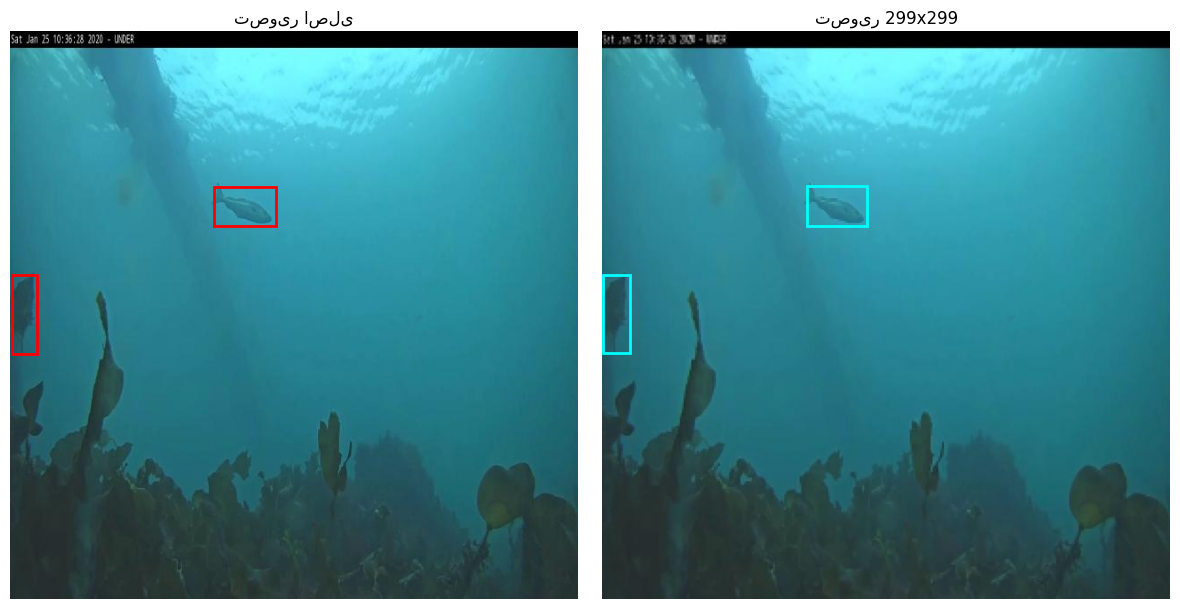


ابعاد باکس در تصویر ریسایز: عرض=32px, ارتفاع=21px


In [176]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from google.colab.patches import cv2_imshow  # فقط برای گوگل کولب

# 1. تنظیم مسیرها
image_path = '/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/1086_png.rf.f7581982f5765b920ee8b023b2efb628.jpg'
xml_path = '/content/drive/MyDrive/Thesis/Projects/Fish-Object Localization and Classification/DataSets/train/1086_png.rf.f7581982f5765b920ee8b023b2efb628.xml'

# 2. خواندن تصویر
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # تبدیل به RGB
original_height, original_width = img.shape[:2]

print(f"ابعاد تصویر اصلی: {original_width}x{original_height}")

# 3. خواندن آنوتیشن
def read_annotation(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    boxes = []
    for member in root.findall('object'):
        bndbox = member.find('bndbox')
        xmin = int(float(bndbox.find('xmin').text))  # تبدیل به float برای اطمینان
        ymin = int(float(bndbox.find('ymin').text))
        xmax = int(float(bndbox.find('xmax').text))
        ymax = int(float(bndbox.find('ymax').text))
        boxes.append([xmin, ymin, xmax, ymax])

    return boxes

boxes = read_annotation(xml_path)
print("مختصات واقعی از XML:", boxes)

# 4. تغییر اندازه تصویر
new_size = (299, 299)
img_resized = cv2.resize(img, new_size)

# 5. محاسبه نسبت تغییر اندازه
scale_x = new_size[0] / original_width
scale_y = new_size[1] / original_height
print(f"نسبت تغییر اندازه: X={scale_x:.4f}, Y={scale_y:.4f}")

# 6. تبدیل مختصات
resized_boxes = []
for box in boxes:
    xmin, ymin, xmax, ymax = box
    xmin_new = int(xmin * scale_x)
    ymin_new = int(ymin * scale_y)
    xmax_new = int(xmax * scale_x)
    ymax_new = int(ymax * scale_y)
    resized_boxes.append([xmin_new, ymin_new, xmax_new, ymax_new])

print("مختصات تبدیل شده:", resized_boxes)

# 7. نمایش نتایج
plt.figure(figsize=(12, 6))

# نمایش تصویر اصلی با باکس‌ها
plt.subplot(1, 2, 1)
plt.imshow(img)
for box in boxes:
    xmin, ymin, xmax, ymax = box
    plt.gca().add_patch(plt.Rectangle(
        (xmin, ymin), xmax-xmin, ymax-ymin,
        fill=False, edgecolor='red', linewidth=2))
plt.title("تصویر اصلی")
plt.axis('off')

# نمایش تصویر ریسایز شده با باکس‌ها
plt.subplot(1, 2, 2)
plt.imshow(img_resized)
for box in resized_boxes:
    xmin, ymin, xmax, ymax = box
    plt.gca().add_patch(plt.Rectangle(
        (xmin, ymin), xmax-xmin, ymax-ymin,
        fill=False, edgecolor='cyan', linewidth=2))
plt.title("تصویر 299x299")
plt.axis('off')

plt.tight_layout()
plt.show()

# 8. نمایش بزرگنمایی شده اگر باکس کوچک است
if len(resized_boxes) > 0:
    xmin, ymin, xmax, ymax = resized_boxes[0]
    print(f"\nابعاد باکس در تصویر ریسایز: عرض={xmax-xmin}px, ارتفاع={ymax-ymin}px")

    if (xmax-xmin) < 10 or (ymax-ymin) < 10:  # اگر باکس خیلی کوچک است
        print("⚠️ توجه: باکس بسیار کوچک است - نمایش حالت بزرگنمایی شده")
        plt.figure(figsize=(8, 8))
        plt.imshow(img_resized)
        plt.gca().add_patch(plt.Rectangle(
            (xmin, ymin), xmax-xmin, ymax-ymin,
            fill=False, edgecolor='lime', linewidth=3))
        plt.xlim(max(0, xmin-20), min(new_size[0], xmax+20))
        plt.ylim(min(new_size[1], ymax+20), max(0, ymin-20))
        plt.title("نمایش بزرگنمایی شده")
        plt.axis('off')
        plt.show()

Box: (0.12, 0.02) to (0.12, 0.03)


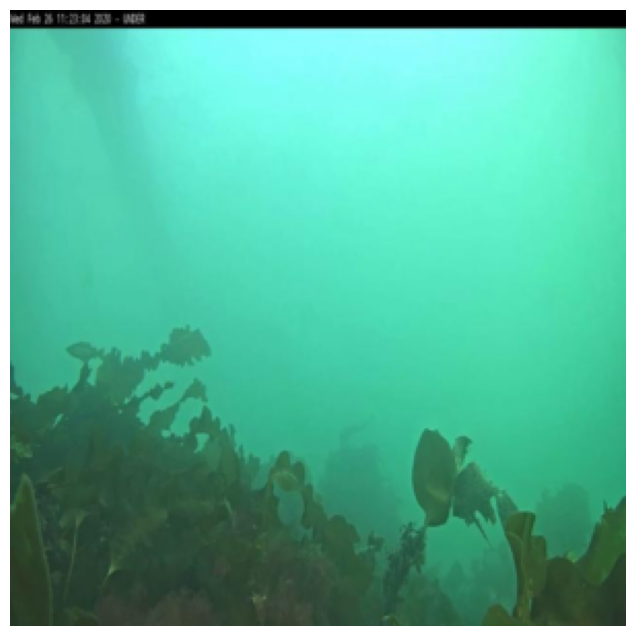

In [117]:
# import matplotlib.pyplot as plt
# import torch
# import numpy as np

# # تابع برای برعکس کردن نرمال‌سازی
# def unnormalize(img, mean, std):
#     img = img.clone()
#     for t, m, s in zip(img, mean, std):
#         t.mul_(s).add_(m)
#     return img


#     # بارگذاری نمونه
# img, lbl, bb, (w, h) = train_ds[5]
# #تغییر رنگ نمونه به حالت اصلی آن
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
# img = unnormalize(img, mean, std)


# # تبدیل به numpy برای نمایش
# img_np = img.permute(1, 2, 0).numpy()
# img_np = np.clip(img_np, 0, 1)

# plt.figure(figsize=(8, 8))
# plt.imshow(img_np)
# plt.axis('off')


# scale_x = sz / w
# scale_y = sz / h


# # رسم کادرها (در حالت نرمال شده یعنی سایز 299*299 چون عکس رسم شده هم همین سایز است)
# for bbox in bb:
#     xmin, ymin, xmax, ymax = bbox

#     xmin = xmin.item()*scale_x
#     ymin = ymin.item()*scale_y
#     xmax = xmax.item()*scale_x
#     ymax = ymax.item()*scale_y

#     print(f"Box: ({xmin:.2f}, {ymin:.2f}) to ({xmax:.2f}, {ymax:.2f})")


#         # نسبت به تصویر نمایشی تغییر مکان
#     display_h, display_w = img_np.shape[:2]

#     plt.gca().add_patch(plt.Rectangle(
#         (xmin, ymin),
#         (xmax - xmin),
#         (ymax - ymin),
#         fill=False, edgecolor='red', linewidth=2))


# plt.show()



## Classification with Localization

<img src='imgs/localization.png' width='90%'/>

### Model

In [113]:
class ClassifierLocalizer(nn.Module):
    def __init__(self, model_name, num_classes=8):
        super(ClassifierLocalizer, self).__init__()
        self.num_classes = num_classes

        # create cnn model
        model = get_model(model_name, num_classes)

        # remove fc layers and add a new fc layer
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes + 4) # classifier + localizer
        self.model = model

    def forward(self, x):
        x = self.model(x)                    # extract features from CNN
        scores = x[:, :self.num_classes]     # class scores
        coords = x[:, self.num_classes:]     # bb corners coordinates
        return scores, torch.sigmoid(coords)     # sigmoid output is in [0, 1]

### Loss Function

Loss function has two parts:
- Cross Entropy Loss (for classification)
- Sum of Squared Errors (for regression)

In [114]:
class LocalizationLoss(nn.Module):
    def __init__(self, num_classes=8):
        super(LocalizationLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss(reduction='sum')
        self.mse_loss = nn.MSELoss(reduction='sum')

    def forward(self, scores, locs, labels, bboxes):
        # Cross Entropy (for classification)
        loss_cls = self.ce_loss(scores, labels)

        # Sum of Squared errors (for corner points)
        loss_r1 = self.mse_loss(locs[:, 0], bboxes[:, 0]) / 2.0
        loss_c1 = self.mse_loss(locs[:, 1], bboxes[:, 1]) / 2.0
        loss_r2 = self.mse_loss(locs[:, 2], bboxes[:, 2]) / 2.0
        loss_c2 = self.mse_loss(locs[:, 3], bboxes[:, 3]) / 2.0

        return loss_cls, loss_r1 + loss_c1 + loss_r2 + loss_c2

In [115]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ClassifierLocalizer(model_name)
model = model.to(device)

criterion = LocalizationLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

In [116]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, scheduler, num_epochs=3)

Epoch 1/3
----------


AttributeError: 'tuple' object has no attribute 'to'

### Predicting bounding boxes

In [ ]:
# load weights
# model.load_state_dict(torch.load('models/resnet34-299-loc-epoch-9-acc-0.97483.pth'))

In [ ]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True)
imgs, lbls, bbs, sizes = next(iter(valid_dl))
scores, locs = model(imgs.to(device))

scores = scores.detach().cpu().numpy()
locs = locs.detach().cpu().numpy()

pred_lbl = np.argmax(scores, axis=1)[0]
pred_bb = locs[0].tolist()

print(pred_lbl, ':', valid_ds.classes[pred_lbl])
w, h = sizes[0].numpy()[0], sizes[1].numpy()[0]

plot_bbox(imgs[0], pred_bb, w, h)

## Other applications

### Key point detection

<img src='imgs/key_points.png' width='80%'/>

### Pose estimation

<img src='imgs/pose.png' width='80%'/>